# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
rewards = []
for _ in range(100):
#     env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    rewards.append(reward)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        rewards = []
        env.reset()

state, action, reward, done, info
[ 0.1494338   0.74310211 -0.22294526 -1.25685002] 0 1.0 True {}
state, action, reward, done, info
[ 0.14908784  1.71650964 -0.22586927 -2.45842004] 1 1.0 True {}
state, action, reward, done, info
[-0.19949973 -0.9691097   0.21407699  1.62433807] 1 1.0 True {}
state, action, reward, done, info
[ 0.22888873  0.62064586 -0.219162   -0.98841598] 0 1.0 True {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
print(rewards[-20:])

[1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [5]:
# class QNetwork:
#     def __init__(self, learning_rate=0.01, state_size=4, action_size=2, hidden_size=10, name='QNetwork'):
#         # state inputs to the Q-network
#         with tf.variable_scope(name):
#             # Given data
#             self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
#             self.actions_ = tf.placeholder(tf.int32, [None], name='actions')

#             # One hot encode the actions to later choose the Q-value for the action
#             one_hot_actions = tf.one_hot(self.actions_, action_size)

#             # ReLU hidden layers
#             fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
#             fc2 = tf.contrib.layers.fully_connected(fc1, hidden_size)

#             # Linear output layer
#             self.output = tf.contrib.layers.fully_connected(fc2, action_size, activation_fn=None)
                    
#             ### Train with loss (targetQ - Q)^2
#             # output has length 2, for two actions. This next line chooses
#             # one value from output (per row) according to the one-hot encoded actions.
#             self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)

#             # Target Q values for training
#             self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')

#             # error backpropagation: loss and opt
#             self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
#             self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

In [69]:
# tf.layers.dense(
#     inputs, --- GOOD
#     units, ----- GOOD
#     activation=None,
#     use_bias=True,  ----------- GOOD
#     kernel_initializer=None,
#     bias_initializer=tf.zeros_initializer(), ----------GOOD
#     kernel_regularizer=None,
#     bias_regularizer=None,
#     activity_regularizer=None,
#     kernel_constraint=None,
#     bias_constraint=None,
#     trainable=True, ----------------- ???
#     name=None,
#     reuse=None
# )

In [70]:
def generator(in_state, state_size=4, action_size=2, hidden_size=10, alpha=0.1, reuse=False, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=in_state, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(nl1, hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits_state_next = tf.layers.dense(nl2, state_size, trainable=False)        
        logits_action = tf.layers.dense(nl2, action_size, trainable=False)        
        # out = tf.tanh(logits)

        return logits_state_next, logits_action

In [71]:
def discriminator(in_state_next, out_action, action_size=2, hidden_size=10, reuse=False, alpha=0.1):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        fused = tf.concat(values=[in_state_next, out_action], axis=1)
        h1 = tf.layers.dense(fused, hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=True)
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(nl1, hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=True)
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(nl2, 1, trainable=False)   
        out = tf.sigmoid(logits)

        # logits for loss and reward/prob/out
        return out, logits

In [72]:
def model_inputs(state_size=4):
    # Current input states
    inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs') # NxCin
    # print(self.inputs_)

    # Current output action: for generation/prediction
    actions_ = tf.placeholder(tf.int32, [None], name='actions')
    # print(actions_)

    # Next input real and generated/fake/predicted
    inputs_next = tf.placeholder(tf.float32, [None, state_size], name='inputs_next') # NxCin
    # print(self.inputs_next)
    
    return inputs_, actions_, inputs_next

In [73]:
def model_loss(inputs_, actions_, inputs_next, action_size=2, hidden_size=10, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param inputs_: real input states given
    :param actions_: real actions given
    :param inputs_next: real next input states given
    :return: A tuple of (discriminator loss, generator loss)
    """
    input_state_gen, out_action_gen = generator(in_state=inputs_, hidden_size=hidden_size)
    _, d_logits_fake = discriminator(in_state_next=input_state_gen, out_action=out_action_gen, hidden_size=hidden_size)
    actions_onehot = tf.one_hot(actions_, action_size)
    _, d_logits_real = discriminator(in_state_next=inputs_next, out_action=actions_onehot, hidden_size=hidden_size, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss

In [74]:
def model_opt(d_loss, g_loss, learning_rate):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor for reward function
    :param g_loss: Generator loss Tensor for action & next state predicton
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

In [75]:
class Net:
    def __init__(self, action_size=2, state_size=4, hidden_size=10, learning_rate=0.01, alpha=0.1):
        tf.reset_default_graph()
        
        # Transfer the data into the framework: model the input/given data
        self.inputs_, self.actions_, self.inputs_next = model_inputs(state_size=state_size)
        
        # Creating the model inside the framework: Model forward prop for caculating the loss
        self.d_loss, self.g_loss = model_loss(inputs_=self.inputs_, actions_=self.actions_, inputs_next=self.inputs_next, 
                                              hidden_size=hidden_size)
        
        # Updating the model inside the framework: Model the backprop for updating the model
        self.d_opt, self.g_opt = model_opt(d_loss=self.d_loss, g_loss=self.g_loss, learning_rate=learning_rate)

In [76]:
# # def generator(in_state, state_size=4, action_size=2, hidden_size=10, name='generator', reuse=False, ):
# #     # state inputs to the Q-network2
# #     with tf.variable_scope(name, reuse=reuse): # for saving the generator weights and biases (model parameters)

# #         # ReLU hidden layers: generators
# #         fc1 = tf.contrib.layers.fully_connected(in_state, hidden_size)
# #         fc2 = tf.contrib.layers.fully_connected(fc1, hidden_size)

# #         # Linear output layer
# #         logits_state_next = tf.contrib.layers.fully_connected(fc2, state_size, activation_fn=None, trainable=False)
# #         logits_action = tf.contrib.layers.fully_connected(fc2, action_size, activation_fn=None, trainable=False)

# #         # # Split it into in and out
# #         # logits_state_next, logits_action = tf.split(value=logits, num_or_size_splits=[state_size, action_size], axis=1)

# #         # logits_action is for applying to the env or env.step and the predicted next state is for D
# #         return logits_state_next, logits_action

# # def discriminator(in_state_next, out_action, action_size=2, hidden_size=10, name='discriminator', reuse=False):
# #     # state inputs to the Q-network2
# #     with tf.variable_scope(name, reuse=reuse):
        
# #         # ReLU hidden layers: discriminator
# #         fused = tf.concat(values=[in_state_next, out_action], axis=1)
# #         # print(in_state_next.shape, out_action.shape, fused.shape)
# #         fc1 = tf.contrib.layers.fully_connected(fused, hidden_size)
# #         fc2 = tf.contrib.layers.fully_connected(fc1, hidden_size)

# #         # Linear output layer: logits and prob/logistics
# #         logits = tf.contrib.layers.fully_connected(fc2, 1, activation_fn=None)
# #         # reward = tf.sigmoid(x=logits) # for reward accumulation -  reward: 0-1

# #         # outputing the logits and prob reward: logits for loss and prob for accumulaion
# #         return logits

# # # This GAN for iDRL
# class Net:
#     def __init__(self, state_size=4, action_size=2, hidden_size=10, learning_rate=0.01):            
#         # Current input states
#         self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs') # NxCin
#         # print(self.inputs_)

#         # Current output action: for generation/prediction
#         self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
#         actions_onehot = tf.one_hot(self.actions_, action_size)
#         # print(actions_onehot)

#         # Next input real and generated/fake/predicted
#         self.inputs_next = tf.placeholder(tf.float32, [None, state_size], name='inputs_next') # NxCin
#         # print(self.inputs_next)

#         # Linear output layer
#         inputs_next_gen, self.output_gen = generator(self.inputs_)

#         # Linear output layer
#         d_logits_fake = discriminator(inputs_next_gen, self.output_gen) # , self.d_reward_fake
#         d_logits_real = discriminator(self.inputs_next, actions_onehot, reuse=True) #, self.d_reward_real

#         d_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_logits_fake, 
#                                                       logits=tf.zeros_like(d_logits_fake))
#         d_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_logits_real, 
#                                                       logits=tf.ones_like(d_logits_real))

#         self.d_loss = d_loss_fake + d_loss_real
#         self.g_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_logits_fake, 
#                                                       logits=tf.ones_like(d_logits_fake))

#         self.d_opt = tf.train.AdamOptimizer(learning_rate).minimize(self.d_loss)
#         self.g_opt = tf.train.AdamOptimizer(learning_rate).minimize(self.g_loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [77]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [82]:
train_episodes = 3000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 10               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [83]:
tf.reset_default_graph()
# mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)
mainNet = Net(hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [84]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards list for plotting
rewards_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(train_episodes):
        total_reward = 0
        
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # # Get action from Q-network
                # feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                # Qs = sess.run(mainQN.output, feed_dict=feed)
                # action = np.argmax(Qs)
                # Get action from GD-network
                feed = {mainNet.inputs_: state.reshape((1, *state.shape))}
                # state_next, action 
                gen = generator(in_state=mainNet.inputs_, reuse=True, training=False)
                _, Qs = sess.run(gen, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
#                       'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                
                # total rewards for plotting
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            # rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # # Train network
            # target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})

            # # Set target_Qs to 0 for states where episode ends
            # episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            # target_Qs[episode_ends] = (0, 0)

            # targets = rewards + gamma * np.max(target_Qs, axis=1)

            # loss, _ = sess.run([mainQN.loss, mainQN.opt],
            #                     feed_dict={mainQN.inputs_: states,
            #                                mainQN.targetQs_: targets,
            #                                mainQN.actions_: actions})
            feed_dict={mainNet.inputs_: states,
                       mainNet.inputs_next: next_states,
                       mainNet.actions_: actions}
            d_loss, _ = sess.run([mainNet.d_loss, mainNet.d_opt], feed_dict)
            g_loss, _ = sess.run([mainNet.g_loss, mainNet.g_opt], feed_dict)
            
    saver.save(sess, "checkpoints/cartpole__.ckpt")

Episode: 0 Total reward: 36.0 Explore P: 0.9964
Episode: 1 Total reward: 12.0 Explore P: 0.9953
Episode: 2 Total reward: 37.0 Explore P: 0.9916
Episode: 3 Total reward: 11.0 Explore P: 0.9905
Episode: 4 Total reward: 9.0 Explore P: 0.9897
Episode: 5 Total reward: 14.0 Explore P: 0.9883
Episode: 6 Total reward: 15.0 Explore P: 0.9868
Episode: 7 Total reward: 13.0 Explore P: 0.9856
Episode: 8 Total reward: 17.0 Explore P: 0.9839
Episode: 9 Total reward: 16.0 Explore P: 0.9823
Episode: 10 Total reward: 24.0 Explore P: 0.9800
Episode: 11 Total reward: 22.0 Explore P: 0.9779
Episode: 12 Total reward: 12.0 Explore P: 0.9767
Episode: 13 Total reward: 35.0 Explore P: 0.9733
Episode: 14 Total reward: 20.0 Explore P: 0.9714
Episode: 15 Total reward: 36.0 Explore P: 0.9680
Episode: 16 Total reward: 14.0 Explore P: 0.9666
Episode: 17 Total reward: 15.0 Explore P: 0.9652
Episode: 18 Total reward: 12.0 Explore P: 0.9640
Episode: 19 Total reward: 30.0 Explore P: 0.9612
Episode: 20 Total reward: 27.0 

Episode: 167 Total reward: 30.0 Explore P: 0.6859
Episode: 168 Total reward: 33.0 Explore P: 0.6836
Episode: 169 Total reward: 24.0 Explore P: 0.6820
Episode: 170 Total reward: 10.0 Explore P: 0.6814
Episode: 171 Total reward: 17.0 Explore P: 0.6802
Episode: 172 Total reward: 19.0 Explore P: 0.6789
Episode: 173 Total reward: 29.0 Explore P: 0.6770
Episode: 174 Total reward: 19.0 Explore P: 0.6757
Episode: 175 Total reward: 32.0 Explore P: 0.6736
Episode: 176 Total reward: 23.0 Explore P: 0.6721
Episode: 177 Total reward: 22.0 Explore P: 0.6706
Episode: 178 Total reward: 27.0 Explore P: 0.6689
Episode: 179 Total reward: 25.0 Explore P: 0.6672
Episode: 180 Total reward: 19.0 Explore P: 0.6660
Episode: 181 Total reward: 18.0 Explore P: 0.6648
Episode: 182 Total reward: 20.0 Explore P: 0.6635
Episode: 183 Total reward: 22.0 Explore P: 0.6620
Episode: 184 Total reward: 16.0 Explore P: 0.6610
Episode: 185 Total reward: 40.0 Explore P: 0.6584
Episode: 186 Total reward: 38.0 Explore P: 0.6559


Episode: 332 Total reward: 21.0 Explore P: 0.5002
Episode: 333 Total reward: 12.0 Explore P: 0.4997
Episode: 334 Total reward: 10.0 Explore P: 0.4992
Episode: 335 Total reward: 10.0 Explore P: 0.4987
Episode: 336 Total reward: 12.0 Explore P: 0.4981
Episode: 337 Total reward: 13.0 Explore P: 0.4975
Episode: 338 Total reward: 12.0 Explore P: 0.4969
Episode: 339 Total reward: 35.0 Explore P: 0.4952
Episode: 340 Total reward: 9.0 Explore P: 0.4947
Episode: 341 Total reward: 12.0 Explore P: 0.4942
Episode: 342 Total reward: 13.0 Explore P: 0.4935
Episode: 343 Total reward: 9.0 Explore P: 0.4931
Episode: 344 Total reward: 31.0 Explore P: 0.4916
Episode: 345 Total reward: 11.0 Explore P: 0.4911
Episode: 346 Total reward: 12.0 Explore P: 0.4905
Episode: 347 Total reward: 13.0 Explore P: 0.4899
Episode: 348 Total reward: 15.0 Explore P: 0.4891
Episode: 349 Total reward: 13.0 Explore P: 0.4885
Episode: 350 Total reward: 11.0 Explore P: 0.4880
Episode: 351 Total reward: 17.0 Explore P: 0.4872
Ep

Episode: 497 Total reward: 20.0 Explore P: 0.3971
Episode: 498 Total reward: 13.0 Explore P: 0.3966
Episode: 499 Total reward: 17.0 Explore P: 0.3959
Episode: 500 Total reward: 13.0 Explore P: 0.3954
Episode: 501 Total reward: 14.0 Explore P: 0.3949
Episode: 502 Total reward: 11.0 Explore P: 0.3945
Episode: 503 Total reward: 11.0 Explore P: 0.3941
Episode: 504 Total reward: 13.0 Explore P: 0.3936
Episode: 505 Total reward: 17.0 Explore P: 0.3929
Episode: 506 Total reward: 13.0 Explore P: 0.3924
Episode: 507 Total reward: 15.0 Explore P: 0.3918
Episode: 508 Total reward: 13.0 Explore P: 0.3913
Episode: 509 Total reward: 14.0 Explore P: 0.3908
Episode: 510 Total reward: 9.0 Explore P: 0.3905
Episode: 511 Total reward: 12.0 Explore P: 0.3900
Episode: 512 Total reward: 19.0 Explore P: 0.3893
Episode: 513 Total reward: 10.0 Explore P: 0.3889
Episode: 514 Total reward: 13.0 Explore P: 0.3884
Episode: 515 Total reward: 17.0 Explore P: 0.3878
Episode: 516 Total reward: 12.0 Explore P: 0.3873
E

Episode: 662 Total reward: 13.0 Explore P: 0.3224
Episode: 663 Total reward: 11.0 Explore P: 0.3220
Episode: 664 Total reward: 11.0 Explore P: 0.3217
Episode: 665 Total reward: 16.0 Explore P: 0.3212
Episode: 666 Total reward: 8.0 Explore P: 0.3209
Episode: 667 Total reward: 9.0 Explore P: 0.3207
Episode: 668 Total reward: 11.0 Explore P: 0.3203
Episode: 669 Total reward: 17.0 Explore P: 0.3198
Episode: 670 Total reward: 11.0 Explore P: 0.3195
Episode: 671 Total reward: 23.0 Explore P: 0.3187
Episode: 672 Total reward: 12.0 Explore P: 0.3184
Episode: 673 Total reward: 12.0 Explore P: 0.3180
Episode: 674 Total reward: 9.0 Explore P: 0.3177
Episode: 675 Total reward: 10.0 Explore P: 0.3174
Episode: 676 Total reward: 9.0 Explore P: 0.3171
Episode: 677 Total reward: 11.0 Explore P: 0.3168
Episode: 678 Total reward: 11.0 Explore P: 0.3165
Episode: 679 Total reward: 9.0 Explore P: 0.3162
Episode: 680 Total reward: 9.0 Explore P: 0.3159
Episode: 681 Total reward: 19.0 Explore P: 0.3153
Episod

Episode: 827 Total reward: 11.0 Explore P: 0.2675
Episode: 828 Total reward: 14.0 Explore P: 0.2672
Episode: 829 Total reward: 8.0 Explore P: 0.2670
Episode: 830 Total reward: 8.0 Explore P: 0.2668
Episode: 831 Total reward: 10.0 Explore P: 0.2665
Episode: 832 Total reward: 10.0 Explore P: 0.2662
Episode: 833 Total reward: 10.0 Explore P: 0.2660
Episode: 834 Total reward: 11.0 Explore P: 0.2657
Episode: 835 Total reward: 13.0 Explore P: 0.2654
Episode: 836 Total reward: 13.0 Explore P: 0.2650
Episode: 837 Total reward: 12.0 Explore P: 0.2647
Episode: 838 Total reward: 8.0 Explore P: 0.2645
Episode: 839 Total reward: 7.0 Explore P: 0.2643
Episode: 840 Total reward: 10.0 Explore P: 0.2641
Episode: 841 Total reward: 8.0 Explore P: 0.2639
Episode: 842 Total reward: 9.0 Explore P: 0.2637
Episode: 843 Total reward: 11.0 Explore P: 0.2634
Episode: 844 Total reward: 12.0 Explore P: 0.2631
Episode: 845 Total reward: 11.0 Explore P: 0.2628
Episode: 846 Total reward: 11.0 Explore P: 0.2625
Episod

Episode: 992 Total reward: 10.0 Explore P: 0.2247
Episode: 993 Total reward: 9.0 Explore P: 0.2245
Episode: 994 Total reward: 9.0 Explore P: 0.2243
Episode: 995 Total reward: 9.0 Explore P: 0.2241
Episode: 996 Total reward: 11.0 Explore P: 0.2239
Episode: 997 Total reward: 10.0 Explore P: 0.2236
Episode: 998 Total reward: 15.0 Explore P: 0.2233
Episode: 999 Total reward: 9.0 Explore P: 0.2231
Episode: 1000 Total reward: 8.0 Explore P: 0.2230
Episode: 1001 Total reward: 11.0 Explore P: 0.2227
Episode: 1002 Total reward: 13.0 Explore P: 0.2224
Episode: 1003 Total reward: 13.0 Explore P: 0.2222
Episode: 1004 Total reward: 19.0 Explore P: 0.2218
Episode: 1005 Total reward: 16.0 Explore P: 0.2214
Episode: 1006 Total reward: 15.0 Explore P: 0.2211
Episode: 1007 Total reward: 18.0 Explore P: 0.2207
Episode: 1008 Total reward: 12.0 Explore P: 0.2205
Episode: 1009 Total reward: 10.0 Explore P: 0.2203
Episode: 1010 Total reward: 11.0 Explore P: 0.2200
Episode: 1011 Total reward: 10.0 Explore P: 

Episode: 1154 Total reward: 10.0 Explore P: 0.1892
Episode: 1155 Total reward: 9.0 Explore P: 0.1891
Episode: 1156 Total reward: 12.0 Explore P: 0.1889
Episode: 1157 Total reward: 9.0 Explore P: 0.1887
Episode: 1158 Total reward: 10.0 Explore P: 0.1885
Episode: 1159 Total reward: 12.0 Explore P: 0.1883
Episode: 1160 Total reward: 11.0 Explore P: 0.1881
Episode: 1161 Total reward: 9.0 Explore P: 0.1880
Episode: 1162 Total reward: 9.0 Explore P: 0.1878
Episode: 1163 Total reward: 8.0 Explore P: 0.1876
Episode: 1164 Total reward: 10.0 Explore P: 0.1875
Episode: 1165 Total reward: 11.0 Explore P: 0.1873
Episode: 1166 Total reward: 10.0 Explore P: 0.1871
Episode: 1167 Total reward: 9.0 Explore P: 0.1869
Episode: 1168 Total reward: 12.0 Explore P: 0.1867
Episode: 1169 Total reward: 10.0 Explore P: 0.1866
Episode: 1170 Total reward: 10.0 Explore P: 0.1864
Episode: 1171 Total reward: 13.0 Explore P: 0.1861
Episode: 1172 Total reward: 14.0 Explore P: 0.1859
Episode: 1173 Total reward: 8.0 Explo

Episode: 1316 Total reward: 7.0 Explore P: 0.1611
Episode: 1317 Total reward: 10.0 Explore P: 0.1609
Episode: 1318 Total reward: 10.0 Explore P: 0.1608
Episode: 1319 Total reward: 10.0 Explore P: 0.1606
Episode: 1320 Total reward: 9.0 Explore P: 0.1605
Episode: 1321 Total reward: 18.0 Explore P: 0.1602
Episode: 1322 Total reward: 7.0 Explore P: 0.1601
Episode: 1323 Total reward: 12.0 Explore P: 0.1599
Episode: 1324 Total reward: 12.0 Explore P: 0.1598
Episode: 1325 Total reward: 10.0 Explore P: 0.1596
Episode: 1326 Total reward: 12.0 Explore P: 0.1594
Episode: 1327 Total reward: 9.0 Explore P: 0.1593
Episode: 1328 Total reward: 13.0 Explore P: 0.1591
Episode: 1329 Total reward: 9.0 Explore P: 0.1590
Episode: 1330 Total reward: 13.0 Explore P: 0.1588
Episode: 1331 Total reward: 13.0 Explore P: 0.1586
Episode: 1332 Total reward: 9.0 Explore P: 0.1584
Episode: 1333 Total reward: 9.0 Explore P: 0.1583
Episode: 1334 Total reward: 8.0 Explore P: 0.1582
Episode: 1335 Total reward: 10.0 Explor

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total Reward')

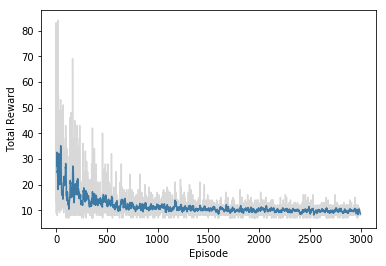

In [22]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

Let's checkout how our trained agent plays the game.

In [13]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/cartpole.ckpt


In [184]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.